In [1]:
from cbio_py import cbio_mod as cb

studies = cb.getAllStudies()
print(f"Total number of studies: {len(studies)}")

# get the 5 study IDs with the most samples
sorted_samples = sorted(studies, key=lambda x: x['allSampleCount'], reverse=True)
print("Top 5 studies with the most samples:")
for studies in sorted_samples[:5]:
    print(f"Study ID: {studies['studyId']}, Sample Count: {studies['allSampleCount']}, Cancer Type: {studies['cancerTypeId']}")
    
print("Overall sample count across all studies:", sum(int(study['allSampleCount']) for study in sorted_samples[:5]))

Total number of studies: 483
Top 5 studies with the most samples:
Study ID: msk_ch_2023, Sample Count: 42714, Cancer Type: mixed
Study ID: msk_met_2021, Sample Count: 25775, Cancer Type: mixed
Study ID: msk_chord_2024, Sample Count: 25040, Cancer Type: mixed
Study ID: msk_ch_2020, Sample Count: 24146, Cancer Type: mixed
Study ID: msk_impact_2017, Sample Count: 10945, Cancer Type: mixed
Overall sample count across all studies: 128620


In [3]:
col_studies = []
count = 0
for study in sorted_samples:
    if study['cancerTypeId'] in ['coad', 'read', 'coadread']:
        print(f"Study ID: {study['studyId']}, Sample Count: {study['allSampleCount']}, Cancer Type: {study['cancerTypeId']}")
        count += 1
        col_studies.append(study)
        
print(f"Total number of studies with 'coad', 'read', or 'coadread' cancer types: {count}")
print(f"Total sample count for these studies: {sum(int(study['allSampleCount']) for study in col_studies)}")

Study ID: crc_msk_2017, Sample Count: 1134, Cancer Type: coadread
Study ID: coadread_tcga, Sample Count: 640, Cancer Type: coadread
Study ID: coadread_dfci_2016, Sample Count: 619, Cancer Type: coadread
Study ID: coadread_tcga_pan_can_atlas_2018, Sample Count: 594, Cancer Type: coadread
Study ID: crc_apc_impact_2020, Sample Count: 471, Cancer Type: coadread
Study ID: coad_tcga_gdc, Sample Count: 463, Cancer Type: coad
Study ID: coad_silu_2022, Sample Count: 348, Cancer Type: coad
Study ID: rectal_msk_2019, Sample Count: 339, Cancer Type: coadread
Study ID: coadread_tcga_pub, Sample Count: 276, Cancer Type: coadread
Study ID: read_tcga_gdc, Sample Count: 171, Cancer Type: read
Study ID: coadread_cass_2020, Sample Count: 146, Cancer Type: coadread
Study ID: coadread_mskcc, Sample Count: 138, Cancer Type: coadread
Study ID: coad_cptac_2019, Sample Count: 110, Cancer Type: coad
Study ID: coad_cptac_gdc, Sample Count: 109, Cancer Type: coad
Study ID: coadread_genentech, Sample Count: 74, Ca

In [4]:
from bravado.client import SwaggerClient
cbioportal = SwaggerClient.from_url('https://www.cbioportal.org/api/v2/api-docs',
                                config={"validate_requests":False,"validate_responses":False,"validate_swagger_spec":False})

gene_mut = []
total_mutations = 0

for study in sorted_samples[:5]:
    # get the mutations for the first sample in each of the top 5 studies
    sample_list = cbioportal.Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET(
        molecularProfileId=f"{study['studyId']}_mutations",
        sampleListId=f"{study['studyId']}_all"
    ).result()
    print(len(sample_list), "mutations found for study:", study['studyId'])
    total_mutations += len(sample_list)
    gene_mut.extend(sample_list)
    
# for study in col_studies:
#     # get the mutations for the first sample in each of the 'coad', 'read', or 'coadread' studies
#     sample_list = cbioportal.Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET(
#         molecularProfileId=f"{study['studyId']}_mutations",
#         sampleListId=f"{study['studyId']}_all"
#     ).result()
#     print(len(sample_list), "mutations found for study:", study['studyId'])
#     total_mutations += len(sample_list)
#     gene_mut.extend(sample_list)
    
print("Total mutations considered:", total_mutations)

21517 mutations found for study: msk_ch_2023
227931 mutations found for study: msk_met_2021
208214 mutations found for study: msk_chord_2024
9813 mutations found for study: msk_ch_2020
78142 mutations found for study: msk_impact_2017
Total mutations considered: 545617


In [5]:
gene_list = cb.getAllGenes(return_type = 'dict')
gene_dict = {gene['entrezGeneId']: gene for gene in gene_list}

In [6]:
# output the mutations to a file
gene_set = set()
with open('../data/top_5_study_mutations.txt', 'w') as f:
    for mutation in gene_mut:
        if not mutation.entrezGeneId:
            print(mutation)
        gene = gene_dict[mutation.entrezGeneId]['hugoGeneSymbol']
        sample_id = mutation.sampleId
        f.write(f"{gene}\t{sample_id}\n")
        gene_set.add(mutation.entrezGeneId)

# output the unique genes to a file
with open('../data/unique_genes_mutated.txt', 'w') as f:
    for gene in gene_set:
        f.write(f"{gene_dict[gene]['hugoGeneSymbol']}\n")

In [9]:
# create a dataframe of the mutations
import pandas as pd
mut_df = pd.read_csv('../data/top_5_study_mutations.txt', sep='\t', header=None, names=['Gene', 'Sample'])
mut_df

,Gene,Sample
0,PIK3CA,P-0000199-N01-IM3
1,PIK3CA,P-0017300-N01-IM6
2,SF3B1,P-0023170-N01-IM6
3,SF3B1,P-0030558-N01-IM6
4,SF3B1,P-0034137-N01-IM6
...,...,...
545612,IRF4,P-0012557-T01-IM5
545613,PTPRD,P-0012622-T01-IM5
545614,ATRX,P-0012622-T01-IM5
545615,TERT,P-0012622-T01-IM5


In [ ]:
gene_mut_dict = {}
for i in range(len(mut_df)):
    if mut_df.iloc[i]['Sample'] not in gene_mut_dict:
        gene_mut_dict[mut_df.iloc[i]['Sample']] = set()
    gene_mut_dict[mut_df.iloc[i]['Sample']].add(mut_df.iloc[i]['Gene'])
    
gene_mut_dict

{'P-0000199-N01-IM3': {'PIK3CA'},
 'P-0017300-N01-IM6': {'NUF2', 'PIK3CA', 'SLX4'},
 'P-0023170-N01-IM6': {'DNMT3A', 'SF3B1', 'SH2B3'},
 'P-0030558-N01-IM6': {'CREBBP', 'DNMT3A', 'SF3B1'},
 'P-0034137-N01-IM6': {'DNMT3A', 'SF3B1'},
 'P-0002984-N01-IM3': {'IDH1'},
 'P-0013309-N01-IM5': {'IDH1'},
 'P-0017038-N01-IM6': {'ASXL1', 'IDH1', 'MLH1'},
 'P-0021405-N01-IM6': {'IDH1'},
 'P-0031300-N01-IM6': {'IDH1'},
 'P-0037199-N01-IM6': {'IDH1'},
 'P-0059678-N01-IM7': {'IDH1', 'PLCG2', 'SRSF2', 'TET2'},
 'P-0059718-N01-IM7': {'CHEK2', 'DNMT3A', 'IDH1'},
 'P-0029603-N01-IM6': {'FBXW7'},
 'P-0013848-N01-IM5': {'DNMT3A', 'TP53'},
 'P-0001393-N01-IM3': {'TP53'},
 'P-0002296-N01-IM3': {'TET2', 'TP53'},
 'P-0024395-N01-IM6': {'DNMT3A', 'NBN', 'TP53'},
 'P-0027841-N01-IM6': {'PPM1D', 'TP53'},
 'P-0029178-N01-IM6': {'IGF2', 'SDHC', 'SF3B1', 'TERT'},
 'P-0031918-N03-IM6': {'SMARCB1', 'STK11'},
 'P-0006880-N01-IM5': {'ATM'},
 'P-0010636-N01-IM5': {'ATM', 'DNMT3A', 'PAK5', 'PPM1D', 'PTPRT'},
 'P-0015496-N0

In [12]:
# Extract unique genes and samples
samples = list(gene_mut_dict.keys())
genes = sorted(set(g for genes in gene_mut_dict.values() for g in genes))

# Create a DataFrame initialized with zeros
df = pd.DataFrame(0, index=samples, columns=genes)

# Populate the DataFrame
for sample, mutated_genes in gene_mut_dict.items():
    df.loc[sample, list(mutated_genes)] = 1

df

,ABL1,ABRAXAS1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALB,ALK,ALOX12B,...,WT1,WWTR1,XIAP,XPO1,XRCC2,YAP1,YES1,ZFHX3,ZNRF3,ZRSR2
P-0000199-N01-IM3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0017300-N01-IM6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0023170-N01-IM6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0030558-N01-IM6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0034137-N01-IM6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P-0012403-T01-IM5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0012423-T01-IM5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
P-0012434-T01-IM5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0012524-T01-IM5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


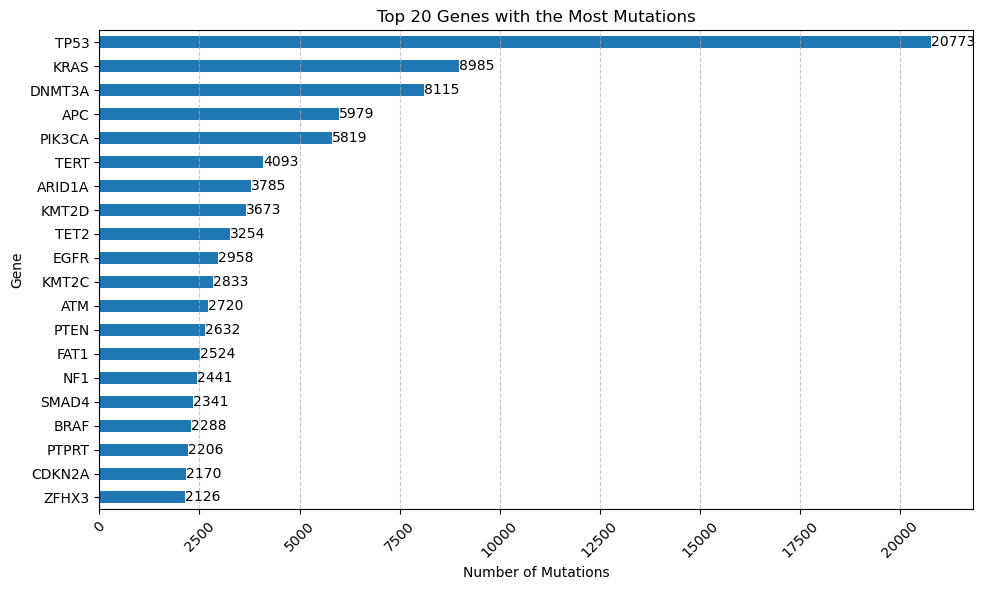

In [13]:
# data analysis
# top 20 genes with the most mutations
import matplotlib.pyplot as plt

top_genes = df.sum().sort_values(ascending=False).head(20)

# in the plot, we want to show the number of mutations for each gene
top_genes.plot(kind='barh', figsize=(10, 6))
plt.title('Top 20 Genes with the Most Mutations')
plt.xlabel('Number of Mutations')
# in each bar, we want to show the gene count/total samples
for index, value in enumerate(top_genes):
    plt.text(value, index, str(value), va='center')
plt.xticks(rotation=45)
plt.gca().invert_yaxis()  # invert y axis to have the highest count on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlabel('Number of Mutations')
plt.ylabel('Gene')
plt.tight_layout()
plt.savefig('../data/top_20_genes_mutations.png')
plt.show()


In [14]:
# save df to a file
df.to_csv('../data/mutation_matrix.csv', index=True)

In [76]:
sample_cd = {}

for study in sorted_samples[:5]:
    print(f"Getting clinical data for study: {study['studyId']}")
    data = cb.getAllClinicalDataInStudy(studyId=study['studyId'])
    print(f"Number of clinical data samples in study {study['studyId']}: {len(data)}")
    
    for sample in data:
        if sample['sampleId'] not in sample_cd:
            sample_cd[sample['sampleId']] = []
            
        sample_cd[sample['sampleId']].append(sample)
        
    print(f"Total number of clinical data for now: {len(sample_cd)}")
        
# write the clinical data to a file
with open('../data/clinical_data.txt', 'w') as f:
    for sample, data in sample_cd.items():
        for d in data:
            f.write(f"{sample}\t{d['clinicalAttributeId']}\t{d['studyId']}\t{d['value']}\n")

Getting clinical data for study: msk_ch_2023
Number of clinical data samples in study msk_ch_2023: 140501
Total number of clinical data for now: 42714
Getting clinical data for study: msk_met_2021
Number of clinical data samples in study msk_met_2021: 1065484
Total number of clinical data for now: 68489
Getting clinical data for study: msk_chord_2024
Number of clinical data samples in study msk_chord_2024: 519147
Total number of clinical data for now: 81396
Getting clinical data for study: msk_ch_2020
Number of clinical data samples in study msk_ch_2020: 86085
Total number of clinical data for now: 105542
Getting clinical data for study: msk_impact_2017
Number of clinical data samples in study msk_impact_2017: 190340
Total number of clinical data for now: 108668


In [77]:
mutation_matrix = pd.read_csv('../data/mutation_matrix.csv')
for sampleid in mutation_matrix['Sample_ID'].values.tolist():
    if sampleid not in sample_cd:
        print(f"Sample ID {sampleid} not found in clinical data for the top 5 studies.")
        
# extend 2 columns to the mutation matrix: msi, stage, initialize with nan
mutation_matrix['MSI'] = float('nan')
mutation_matrix['Stage'] = float('nan')
mutation_matrix

,Sample_ID,ABL1,ABRAXAS1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALB,ALK,...,XIAP,XPO1,XRCC2,YAP1,YES1,ZFHX3,ZNRF3,ZRSR2,MSI,Stage
0,P-0000199-N01-IM3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,P-0017300-N01-IM6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,P-0023170-N01-IM6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
3,P-0030558-N01-IM6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
4,P-0034137-N01-IM6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58990,P-0012403-T01-IM5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
58991,P-0012423-T01-IM5,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,NaN,NaN
58992,P-0012434-T01-IM5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
58993,P-0012524-T01-IM5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN


In [80]:
total_case = len(mutation_matrix)
msi_count = 0
stage_count = 0

for id in mutation_matrix['Sample_ID'].values.tolist():
    for cd_data in sample_cd[id]:
        if cd_data['clinicalAttributeId'] == 'PATHOLOGICAL_GROUP' or cd_data['clinicalAttributeId'] == 'CLINICAL_STAGE':
            if cd_data['clinicalAttributeId'] == 'PATHOLOGICAL_GROUP':
            # for pathological group, we want to use the value as stage
                mutation_matrix.loc[mutation_matrix['Sample_ID'] == id, 'Stage'] = cd_data['value']
            elif cd_data['clinicalAttributeId'] == 'CLINICAL_STAGE':
                mutation_matrix.loc[mutation_matrix['Sample_ID'] == id, 'Stage'] = cd_data['value']
            stage_count += 1
            
        if cd_data['clinicalAttributeId'] == 'MSI_TYPE':
            mutation_matrix.loc[mutation_matrix['Sample_ID'] == id, 'MSI'] = cd_data['value']
            msi_count += 1

print(f"Total samples with stage data: {stage_count}/{total_case}")
print(f"Total samples with msi data: {msi_count}/{total_case}")
        
# # sampleId=P-0001534-T01-IM3&studyId=msk_chord_2024
# cb.getAllClinicalDataOfSampleInStudy(studyId='msk_chord_2024', sampleId='P-0001534-T01-IM3')

Total samples with stage data: 16909/58995
Total samples with msi data: 48227/58995


In [82]:
mutation_matrix.to_csv('../data/mutation_matrix_with_clinical_data.csv', index=False)

In [2]:
from bravado.client import SwaggerClient
cbioportal = SwaggerClient.from_url('https://www.cbioportal.org/api/v2/api-docs',
                                config={"validate_requests":False,"validate_responses":False,"validate_swagger_spec":False})

gene_mut = []
total_mutations = 0


# get the mutations for the first sample in each of the top 5 studies
sample_list = cbioportal.Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET(
    molecularProfileId=f"msk_chord_2024_mutations",
    sampleListId=f"msk_chord_2024_all"
).result()
print(len(sample_list), "mutations found for study:", 'msk_chord_2024')
total_mutations += len(sample_list)
gene_mut.extend(sample_list)
    
print("Total mutations considered:", total_mutations)

208214 mutations found for study: msk_chord_2024
Total mutations considered: 208214


In [3]:
gene_mut[0]

Mutation(alleleSpecificCopyNumber=None, aminoAcidChange=None, center='MSKCC', chr='19', driverFilter=None, driverFilterAnnotation=None, driverTiersFilter=None, driverTiersFilterAnnotation=None, endPosition=5211674, entrezGeneId=5802, gene=None, keyword='PTPRS R1721 missense', molecularProfileId='msk_chord_2024_mutations', mutationStatus='SOMATIC', mutationType='Missense_Mutation', namespaceColumns=None, ncbiBuild='GRCh37', normalAltCount=5, normalRefCount=806, patientId='P-0000012', proteinChange='R1721W', proteinPosEnd=1721, proteinPosStart=1721, referenceAllele='G', refseqMrnaId='NM_002850.3', sampleId='P-0000012-T03-IM3', startPosition=5211674, studyId='msk_chord_2024', tumorAltCount=42, tumorRefCount=255, uniquePatientKey='UC0wMDAwMDEyOm1za19jaG9yZF8yMDI0', uniqueSampleKey='UC0wMDAwMDEyLVQwMy1JTTM6bXNrX2Nob3JkXzIwMjQ', validationStatus='Unknown', variantAllele='A', variantType='SNP')

In [5]:
gene_list = cb.getAllGenes(return_type = 'dict')
gene_dict = {gene['entrezGeneId']: gene for gene in gene_list}

# output the mutations to a file
gene_set = set()
with open('../data/msk_2024_mutations.txt', 'w') as f:
    f.write("Gene\tSample\tPatient\tmutationType\tvariantType\tproteinChange\tchr\tstartPosition\tendPosition\treferenceAllele\tvariantAllele\tproteinPosStart\tproteinPosEnd\tmutationStatus\ttumorAltCount\ttumorRefCount\tnormalAltCount\tnormalRefCount\n")
    for mutation in gene_mut:
        if not mutation.entrezGeneId:
            print(mutation)
        gene = gene_dict[mutation.entrezGeneId]['hugoGeneSymbol']
        sample_id = mutation.sampleId
        f.write(f"{gene}\t{sample_id}\t{mutation.patientId}\t{mutation.mutationType}\t{mutation.variantType}\t{mutation.proteinChange}\t{mutation.chr}\t{mutation.startPosition}\t{mutation.endPosition}\t{mutation.referenceAllele}\t{mutation.variantAllele}\t{mutation.proteinPosStart}\t{mutation.proteinPosEnd}\t{mutation.mutationStatus}\t{mutation.tumorAltCount}\t{mutation.tumorRefCount}\t{mutation.normalAltCount}\t{mutation.normalRefCount}\n")
        gene_set.add(mutation.entrezGeneId)

In [10]:
data = cb.getAllClinicalDataInStudy(studyId='msk_chord_2024')
data[:50]


[{'clinicalAttribute': None,
  'clinicalAttributeId': 'CANCER_TYPE',
  'patientAttribute': None,
  'patientId': 'P-0000012',
  'sampleId': 'P-0000012-T03-IM3',
  'studyId': 'msk_chord_2024',
  'uniquePatientKey': 'UC0wMDAwMDEyOm1za19jaG9yZF8yMDI0',
  'uniqueSampleKey': 'UC0wMDAwMDEyLVQwMy1JTTM6bXNrX2Nob3JkXzIwMjQ',
  'value': 'Non-Small Cell Lung Cancer'},
 {'clinicalAttribute': None,
  'clinicalAttributeId': 'CANCER_TYPE_DETAILED',
  'patientAttribute': None,
  'patientId': 'P-0000012',
  'sampleId': 'P-0000012-T03-IM3',
  'studyId': 'msk_chord_2024',
  'uniquePatientKey': 'UC0wMDAwMDEyOm1za19jaG9yZF8yMDI0',
  'uniqueSampleKey': 'UC0wMDAwMDEyLVQwMy1JTTM6bXNrX2Nob3JkXzIwMjQ',
  'value': 'Lung Adenocarcinoma'},
 {'clinicalAttribute': None,
  'clinicalAttributeId': 'CLINICAL_GROUP',
  'patientAttribute': None,
  'patientId': 'P-0000012',
  'sampleId': 'P-0000012-T03-IM3',
  'studyId': 'msk_chord_2024',
  'uniquePatientKey': 'UC0wMDAwMDEyOm1za19jaG9yZF8yMDI0',
  'uniqueSampleKey': 'UC0wMD

In [12]:
data_1 = cb.getClinicalAttributesByStudyId(studyId='msk_chord_2024')
data_1

[{'clinicalAttributeId': 'ADRENAL_GLANDS',
  'datatype': 'STRING',
  'description': 'DESCRIPTION: History of Adrenal Gland as a tumor site as indicated in radiology report impression ---MISSING DATA: No CT/PET/MRI radiology report available for patient. impression section MISSING from report. ---SOURCE:(CDM) Generated (NLP)',
  'displayName': 'Tumor Site: Adrenal Glands (NLP)',
  'patientAttribute': True,
  'priority': '0',
  'studyId': 'msk_chord_2024'},
 {'clinicalAttributeId': 'BONE',
  'datatype': 'STRING',
  'description': 'DESCRIPTION: History of Bone as a tumor site as indicated in radiology report impression ---MISSING DATA: No CT/PET/MRI radiology report available for patient. impression section MISSING from report. ---SOURCE:(CDM) Generated (NLP)',
  'displayName': 'Tumor Site: Bone (NLP)',
  'patientAttribute': True,
  'priority': '0',
  'studyId': 'msk_chord_2024'},
 {'clinicalAttributeId': 'CANCER_TYPE',
  'datatype': 'STRING',
  'description': 'The main cancer type as def

In [11]:
data_2 = cb.getAllPatientsInStudy(studyId='msk_chord_2024')
data_2

[{'cancerStudy': None,
  'patientId': 'P-0000012',
  'studyId': 'msk_chord_2024',
  'uniquePatientKey': 'UC0wMDAwMDEyOm1za19jaG9yZF8yMDI0',
  'uniqueSampleKey': None},
 {'cancerStudy': None,
  'patientId': 'P-0000015',
  'studyId': 'msk_chord_2024',
  'uniquePatientKey': 'UC0wMDAwMDE1Om1za19jaG9yZF8yMDI0',
  'uniqueSampleKey': None},
 {'cancerStudy': None,
  'patientId': 'P-0000036',
  'studyId': 'msk_chord_2024',
  'uniquePatientKey': 'UC0wMDAwMDM2Om1za19jaG9yZF8yMDI0',
  'uniqueSampleKey': None},
 {'cancerStudy': None,
  'patientId': 'P-0000041',
  'studyId': 'msk_chord_2024',
  'uniquePatientKey': 'UC0wMDAwMDQxOm1za19jaG9yZF8yMDI0',
  'uniqueSampleKey': None},
 {'cancerStudy': None,
  'patientId': 'P-0000066',
  'studyId': 'msk_chord_2024',
  'uniquePatientKey': 'UC0wMDAwMDY2Om1za19jaG9yZF8yMDI0',
  'uniqueSampleKey': None},
 {'cancerStudy': None,
  'patientId': 'P-0000058',
  'studyId': 'msk_chord_2024',
  'uniquePatientKey': 'UC0wMDAwMDU4Om1za19jaG9yZF8yMDI0',
  'uniqueSampleKey':

In [15]:
data3 = cb.getClinicalAttributeInStudy(studyId='msk_chord_2024', clinicalAttributeId='OS_MONTHS')
data3

{'clinicalAttributeId': 'OS_MONTHS',
 'datatype': 'NUMBER',
 'description': "DESCRIPTION: Overall survival from date of first sequenced sample to date of death or last contact. If patient died before first sequencing, overall survival in months is set to '0'. If patient is alive and last contact date is before date of sequencing,overall survival in months is set to 'NA'. Derived from PT_DEATH_DTE, PLA_LAST_CONTACT_DTE and date of sequencing for first specimen sequenced for patient. ---MISSING DATA: Last contact date, sequencing date missing in RMS ---SOURCE:CDM Generated (Via IDB/RMS dates)",
 'displayName': 'Overall Survival (Months)',
 'patientAttribute': True,
 'priority': '0',
 'studyId': 'msk_chord_2024'}

In [16]:
data_4 = cb.getAllClinicalDataOfPatientInStudy(studyId='msk_chord_2024', patientId='P-0002773')
data_4

[{'clinicalAttribute': None,
  'clinicalAttributeId': 'ADRENAL_GLANDS',
  'patientAttribute': None,
  'patientId': 'P-0002773',
  'sampleId': None,
  'studyId': 'msk_chord_2024',
  'uniquePatientKey': 'UC0wMDAyNzczOm1za19jaG9yZF8yMDI0',
  'uniqueSampleKey': None,
  'value': 'No'},
 {'clinicalAttribute': None,
  'clinicalAttributeId': 'BONE',
  'patientAttribute': None,
  'patientId': 'P-0002773',
  'sampleId': None,
  'studyId': 'msk_chord_2024',
  'uniquePatientKey': 'UC0wMDAyNzczOm1za19jaG9yZF8yMDI0',
  'uniqueSampleKey': None,
  'value': 'Yes'},
 {'clinicalAttribute': None,
  'clinicalAttributeId': 'CNS_BRAIN',
  'patientAttribute': None,
  'patientId': 'P-0002773',
  'sampleId': None,
  'studyId': 'msk_chord_2024',
  'uniquePatientKey': 'UC0wMDAyNzczOm1za19jaG9yZF8yMDI0',
  'uniqueSampleKey': None,
  'value': 'Yes'},
 {'clinicalAttribute': None,
  'clinicalAttributeId': 'CURRENT_AGE_DEID',
  'patientAttribute': None,
  'patientId': 'P-0002773',
  'sampleId': None,
  'studyId': 'msk

In [31]:
import pandas as pd

df = pd.read_csv('../data/msk_2024_mutations.txt', sep='\t')
df.head()

print(len(df['Sample'].unique()), "unique samples in the mutation data")
print(len(df['Patient'].unique()), "unique patients in the mutation data")

# how many patient has more than 1 sample
patient_sample_count = df.groupby('Patient')['Sample'].nunique()
print("Number of patients with more than 1 sample:")
print(patient_sample_count[patient_sample_count > 1].count())
print("Number of patients with only 1 sample:")
print(patient_sample_count[patient_sample_count == 1].count())
print("Number of patients with less 1 sample:")
print(patient_sample_count[patient_sample_count < 1].count())

# exclude the patients with more than 1 sample
df_single = df[df['Patient'].isin(patient_sample_count[patient_sample_count == 1].index)]
print(len(df_single['Sample'].unique()), "unique samples in the mutation data after excluding patients with more than 1 sample")
print(len(df_single['Patient'].unique()), "unique patients in the mutation data after excluding patients with more than 1 sample")

23862 unique samples in the mutation data
23780 unique patients in the mutation data
Number of patients with more than 1 sample:
82
Number of patients with only 1 sample:
23698
Number of patients with less 1 sample:
0
23698 unique samples in the mutation data after excluding patients with more than 1 sample
23698 unique patients in the mutation data after excluding patients with more than 1 sample


In [32]:
print(f"Mutation Type: {df_single['mutationType'].unique()} ({len(df_single['mutationType'].unique())})")   
print(f"Variant Type: {df_single['variantType'].unique()} ({len(df_single['variantType'].unique())})")
print(f"Protein Change: {df_single['proteinChange'].unique()} ({len(df_single['proteinChange'].unique())})")
print(f"Chromosome: {df_single['chr'].unique()} ({len(df_single['chr'].unique())})")
print(f"Start Position: {df_single['startPosition'].unique()} ({len(df_single['startPosition'].unique())})")
print(f"End Position: {df_single['endPosition'].unique()} ({len(df_single['endPosition'].unique())})")
print(f"Reference Allele: {df_single['referenceAllele'].unique()} ({len(df_single['referenceAllele'].unique())})")
print(f"Variant Allele: {df_single['variantAllele'].unique()} ({len(df_single['variantAllele'].unique())})")
print(f"Protein Position Start: {df_single['proteinPosStart'].unique()} ({len(df_single['proteinPosStart'].unique())})")
print(f"Protein Position End: {df_single['proteinPosEnd'].unique()} ({len(df_single['proteinPosEnd'].unique())})")
print(f"Mutation Status: {df_single['mutationStatus'].unique()} ({len(df_single['mutationStatus'].unique())})")
print(f"Tumor Alt Count: {df_single['tumorAltCount'].unique()} ({len(df_single['tumorAltCount'].unique())})")
print(f"Tumor Ref Count: {df_single['tumorRefCount'].unique()} ({len(df_single['tumorRefCount'].unique())})")
print(f"Normal Alt Count: {df_single['normalAltCount'].unique()} ({len(df_single['normalAltCount'].unique())})")
print(f"Normal Ref Count: {df_single['normalRefCount'].unique()} ({len(df_single['normalRefCount'].unique())})")

df_single

Mutation Type: ['Missense_Mutation' 'Frame_Shift_Ins' 'Nonsense_Mutation' 'In_Frame_Del'
 'Splice_Site' 'Frame_Shift_Del' 'In_Frame_Ins' "5'Flank"
 'Translation_Start_Site' 'Nonstop_Mutation' 'Splice_Region'
 'nonsynonymous_SNV' 'frameshift_insertion'] (13)
Variant Type: ['SNP' 'INS' 'DEL' 'DNP' 'TNP' 'ONP' 'MNP'] (7)
Protein Change: ['E545K' 'R248W' 'D335Gfs*17' ... 'E2097K' 'H2540L' 'S2542Yfs*20'] (97514)
Chromosome: [ 3 17 10  6  2 12 14 23  4  5  7 22 15 19  1  9 13 16 11 20 18  8 21] (23)
Start Position: [178936091   7577539   8111513 ... 108188190 151874919 151874913] (123199)
End Position: [178936091   7577539   8111514 ... 108188190 151874919 151874913] (122453)
Reference Allele: ['G' '-' 'T' ... 'GCGCCCA'
 'GAATTCCTGACCTTTGTATAAGTAACCCGCCCTCCTCGGGCTCCCACAGTACTGGGATTACAAGGCGTGAGCCGCCACTATCGGCCATTTTGAAGACAATGGCCAAGACACAAAAGCCTAGTTTAGAAGAGCCACCGGCCCTGCCCCCATCCCCTAACCCTCCACCCTCCTTGTTTTAGGAGACATTACTCCCTAGTGCTACGGCGCTTTCAACTGAAATTGTTGGTGGCTCTGAAAAGAGCCTTTGGTTTAAGTTGGCGCACACCCTCAGTAC

,Gene,Sample,Patient,mutationType,variantType,proteinChange,chr,startPosition,endPosition,referenceAllele,variantAllele,proteinPosStart,proteinPosEnd,mutationStatus,tumorAltCount,tumorRefCount,normalAltCount,normalRefCount
31,PIK3CA,P-0000015-T01-IM3,P-0000015,Missense_Mutation,SNP,E545K,3,178936091,178936091,G,A,545,545,SOMATIC,56,80,0,349
32,TP53,P-0000015-T01-IM3,P-0000015,Missense_Mutation,SNP,R248W,17,7577539,7577539,G,A,248,248,SOMATIC,61,131,0,635
33,GATA3,P-0000015-T01-IM3,P-0000015,Frame_Shift_Ins,INS,D335Gfs*17,10,8111513,8111514,-,G,333,335,SOMATIC,75,378,0,967
34,ESR1,P-0000015-T01-IM3,P-0000015,Missense_Mutation,SNP,L536H,6,152419920,152419920,T,A,536,536,SOMATIC,45,78,0,558
35,ALK,P-0000015-T01-IM3,P-0000015,Missense_Mutation,SNP,G940D,2,29450535,29450535,C,T,940,940,SOMATIC,47,196,1,881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208209,YAP1,P-0009406-T01-IM3,P-0009406,Missense_Mutation,SNP,D234H,11,102056760,102056760,G,C,234,234,UNKNOWN,101,284,0,396
208210,ATM,P-0009406-T01-IM3,P-0009406,Missense_Mutation,SNP,E2097K,11,108188190,108188190,G,A,2097,2097,UNKNOWN,105,454,0,347
208211,KMT2C,P-0009406-T01-IM3,P-0009406,Missense_Mutation,SNP,H2540L,7,151874919,151874919,T,A,2540,2540,UNKNOWN,193,423,0,413
208212,KMT2C,P-0009406-T01-IM3,P-0009406,Frame_Shift_Del,DEL,S2542Yfs*20,7,151874913,151874913,G,-,2542,2542,UNKNOWN,193,417,0,404


In [33]:
# select mutationType, variantType, chr, startPosition, endPosition, proteinPosStart, proteinPosEnd, tumorAlleleFreq = tumorAltCount/(tumorAltCount + tumorRefCount), normalAlleleFreq = normalAltCount/(normalAltCount + normalRefCount)
df_single['tumorAlleleFreq'] = df_single['tumorAltCount'] / (df_single['tumorAltCount'] + df_single['tumorRefCount'])
df_single['normalAlleleFreq'] = df_single['normalAltCount'] / (df_single['normalAltCount'] + df_single['normalRefCount'])

df_clean = df_single[['Gene', 'Sample', 'Patient', 'mutationType', 'variantType', 'chr', 'startPosition', 'endPosition',
                       'proteinPosStart', 'proteinPosEnd', 'tumorAlleleFreq', 'normalAlleleFreq']]
df_clean.to_csv('../data/msk_2024_mutations_clean.csv', index=False)
df_clean.head()

/tmp/ipykernel_23089/1797425824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single['tumorAlleleFreq'] = df_single['tumorAltCount'] / (df_single['tumorAltCount'] + df_single['tumorRefCount'])
/tmp/ipykernel_23089/1797425824.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single['normalAlleleFreq'] = df_single['normalAltCount'] / (df_single['normalAltCount'] + df_single['normalRefCount'])


,Gene,Sample,Patient,mutationType,variantType,chr,startPosition,endPosition,proteinPosStart,proteinPosEnd,tumorAlleleFreq,normalAlleleFreq
31,PIK3CA,P-0000015-T01-IM3,P-0000015,Missense_Mutation,SNP,3,178936091,178936091,545,545,0.411765,0.000000
32,TP53,P-0000015-T01-IM3,P-0000015,Missense_Mutation,SNP,17,7577539,7577539,248,248,0.317708,0.000000
33,GATA3,P-0000015-T01-IM3,P-0000015,Frame_Shift_Ins,INS,10,8111513,8111514,333,335,0.165563,0.000000
34,ESR1,P-0000015-T01-IM3,P-0000015,Missense_Mutation,SNP,6,152419920,152419920,536,536,0.365854,0.000000
35,ALK,P-0000015-T01-IM3,P-0000015,Missense_Mutation,SNP,2,29450535,29450535,940,940,0.193416,0.001134


In [ ]:
df['chr'] = df['chr'].astype(str)  # ensure string type if numeric chromosome
categorical_cols = ['mutationType', 'variantType', 'chr']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)